In [40]:
# Wavefunction generation
from pyscf import mcscf, fci, lib 
from pyscf import gto, scf, tools, dft
import api as pyq 
import importlib
import os
import h5py
import pandas as pd
import pdb
import pyscf
import numpy as np
import pyqmc
import scipy
import matplotlib.pyplot as plt
from pyscf.scf.hf import dump_scf_summary
from concurrent.futures import ProcessPoolExecutor
from pyscf.scf.chkfile import dump_scf
print(pyq.__file__)
print(pyscf.__file__)

/Users/ksu/Documents/GitHub/pyqmc2/pyqmc/pyqmc/api.py
/Users/ksu/Software/anaconda3/lib/python3.11/site-packages/pyscf/__init__.py


In [46]:
# H2 molecule
def run_scf(scf_checkfile):
    mol = gto.M(atom="H 0. 0. 0.;H 0. 0. 1.;", basis=f'ccecpccpvdz', unit='bohr')
    mf = scf.UHF(mol)
    mf.chkfile = scf_checkfile
    dm = mf.init_guess_by_atom()
    mf.kernel(dm)
    dump_scf(mf.mol, 'scf.hdf5', mf.energy_tot(), mf.mo_energy, mf.mo_coeff, mf.mo_occ)
    return mf

def run_lda_be(scf_checkfile):
    print("Be atom neutral LDA spin=2")
    mol = gto.M(atom="Be 0. 0. 0.", spin=2,basis=f'ccpvdz', unit='bohr')
    print("HF")
    mf = scf.UHF(mol)
    mf.kernel()
    print("LDA")        
    mf = dft.UKS(mol)
    # mf.verbose=6
    mf.chkfile = scf_checkfile
    dm = mf.init_guess_by_atom()
    mf.kernel(dm, xc='LDA')
    return mf

def run_lda_li(scf_checkfile):
    print("Li atom neutral LDA spin=1")
    mol = gto.M(atom="Li 0. 0. 0.",basis=f'ccpvtz', spin=1, unit='bohr')
    print("HF")
    mf = scf.UHF(mol)
    mf.kernel()
    print("LDA")    
    mf = dft.UKS(mol)
    # mf.verbose=6
    mf.chkfile = scf_checkfile
    dm = mf.init_guess_by_atom()
    mf.kernel(dm, xc='LDA')
    return mf

def run_lda_he(scf_checkfile):
    print("He atom neutral LDA spin=0")
    # mol = gto.M(atom="He 0. 0. 0.", basis="ccECP_cc-pVDZ", ecp="ccecp", unit='bohr')
    mol = gto.M(atom="He 0. 0. 0.", basis="ccpvdz", unit='bohr')    
    print("HF")
    mf = scf.UHF(mol)
    mf.kernel()
    print("LDA")    
    mf = dft.UKS(mol)
    # mf.verbose=6
    mf.chkfile = scf_checkfile
    dm = mf.init_guess_by_atom()
    mf.kernel(dm, xc='LDA')
    return mf

def run_lda_h2(scf_checkfile):
    mol = gto.M(atom="H 0. 0. 0.; H 0. 0. 2", spin = 2, basis=f'ccecpccpvdz', unit='bohr')
    mf = dft.UKS(mol)
    # mf.verbose=6
    mf.chkfile = scf_checkfile
    dm = mf.init_guess_by_atom()
    mf.xc='LDA, VWN'
    mf.kernel()    
    # mf.kernel(dm, xc='LDA,VWN')
    return mf

def run_lda(scf_checkfile):
    mol = gto.M(atom="H 0. 0. 0.", spin=1,basis=f'ccecpccpvdz', unit='bohr')
    mf = dft.UKS(mol)
    # mf.verbose=6
    mf.chkfile = scf_checkfile
    dm = mf.init_guess_by_atom()
    mf.kernel(dm, xc='LDA')
    return mf
    
def run_casscf(scf_checkfile, ci_checkfile):
    cell, mf = pyq.recover_pyscf(scf_checkfile, cancel_outputs=False)
    mc = mcscf.CASSCF(mf,2,2)
    mc.chkfile = ci_checkfile
    mc.kernel()
    with h5py.File(mc.chkfile, "a") as f:
        print("Available output from CASSCF:", f["mcscf"].keys())
        f["mcscf/nelecas"] = list(mc.nelecas)
        f["mcscf/ci"] = mc.ci
    return mc

def run_casci(scf_checkfile, ci_checkfile):
    cell, mf = pyq.recover_pyscf(scf_checkfile, cancel_outputs=False)
    # ncas: orbitals
    # nelecas: electrons
    ncas = 4
    nelecas = 2
    mc = mcscf.CASCI(mf, ncas, nelecas)
    mc.kernel()
    print(mc.__dict__.keys())
    with h5py.File(ci_checkfile, "a") as f:
        f.create_group("ci")
        f["ci/ncas"] = mc.ncas
        f["ci/nelecas"] = list(mc.nelecas)
        f["ci/ci"] = mc.ci
        f["ci/mo_coeff"] = mc.mo_coeff
        print("Available output from CASCI:", f["ci"].keys())
    return mc

def make_wf_object(scf_checkfile, ci_checkfile):
    mol, mf, mc = pyq.recover_pyscf(scf_checkfile, ci_checkfile=ci_checkfile)
    wf, _ = pyq.generate_wf(mol, mf, mc=mc)
    return wf

def stat_qmc(etot, filename):
    block_sizes = np.linspace(2,len(etot[discard:])//16, 10, dtype=int)
    reblocks = [len(etot)//s for s in block_sizes]

    plt.figure()
    df = pd.DataFrame([pyq.read_mc_output(filename, warmup=discard, reblock=reblock) for reblock in reblocks])
    df['block_size'] = block_sizes
    plt.plot("block_size",'energytotal_err',data=df, marker='o')
    plt.xlabel("Block size")
    plt.ylabel("Estimated uncertainty (Ha)")

def reblock(e, discard, reblock_size):
    e = e[discard:]
    vals = pyqmc.reblock.reblock(e,int(len(e)/reblock_size))
    # import pdb
    # pdb.set_trace()
    
    e_m  = np.mean(vals, axis=0)
    e_d  = scipy.stats.sem(vals, axis=0)    
    return e, e_m, e_d

scf_checkfile = "scf.hdf5"
ci_checkfile = "ci.hdf5"
# mf = run_scf(scf_checkfile)
mf_lda = run_lda_be(scf_checkfile)

# mc = run_casci(scf_checkfile, ci_checkfile)

Be atom neutral LDA spin=2
HF
converged SCF energy = -14.5119275266939  <S^2> = 2.0000034  2S+1 = 3.0000023
LDA
converged SCF energy = -14.3541362022289  <S^2> = 2.0000041  2S+1 = 3.0000028


In [47]:
import importlib, recipes, bosonrecipes, bosonslater, bosonwf, bosonaccumulators, bosonjastrowspin, bosonlinemin, bosonmc, bosonmultiplywf, bosonwftools 
modules = [recipes, bosonrecipes, bosonrecipes, bosonslater, bosonwf, bosonaccumulators, bosonjastrowspin, bosonlinemin, bosonmc, bosonmultiplywf, bosonwftools] # Reloads recipes.py file after each update
for m in modules:
    importlib.reload(m)

    # Jastrow optimizationn
    
for fname in ['sj.hdf5']:
    if os.path.isfile(fname):
        os.remove(fname)

# pyq.OPTIMIZE(scf_checkfile, "sj.hdf5", ci_checkfile=ci_checkfile, max_iterations=2, verbose=False)
# bosonrecipes.ABOPTIMIZE(scf_checkfile, "sj.hdf5", max_iterations=2, nconfig=100, verbose=False)
recipes.OPTIMIZE(scf_checkfile, "sj.hdf5", max_iterations=5, nconfig=1000, verbose=False)
# Jastrow optimization results
df = pyq.read_opt("sj.hdf5")
df

step  0
step  1
step  2
step  3
step  4


,energy,iteration,error,fname
0,-14.001176,0,0.193588,sj.hdf5
1,-11.674860,1,0.182114,sj.hdf5
2,-10.323343,2,0.074085,sj.hdf5
3,-9.489546,3,0.138127,sj.hdf5
4,-8.084029,4,0.275783,sj.hdf5


In [48]:
tstep = 0.001
nconfig = 2000
nsteps = 1000
discard = 100
reblock_size = 50

In [49]:
import importlib, recipes, abdmc, wftools, bosonslater, bosonwftools, determinant_tools, mc, dmc, slater, orbitals, accumulators, energy, jastrowspin, multiplywf
modules = [recipes, abdmc, wftools, bosonslater, bosonwftools, determinant_tools, mc, dmc, slater, orbitals, accumulators, energy, jastrowspin, multiplywf] # Reloads recipes.py file after each update
for m in modules:
    importlib.reload(m)
import pyqmc.pyscftools as pyscftools

def initialize_boson_qmc_objects_j(
    dft_checkfile,
):  
    mol, mf = pyscftools.recover_pyscf(scf_checkfile)
    wf, to_opt = bosonwftools.generate_boson_wf(
        mol, mf,
    )
    load_parameters = 'sj.hdf5'
    wftools.read_wf(wf, load_parameters)      
    return wf

def initialize_qmc_objects_j(
    dft_checkfile: str,
):
    mol, mf = pyscftools.recover_pyscf(dft_checkfile)
    wf, to_opt = wftools.generate_wf(
        mol, mf, 
    )
    load_parameters = 'sj.hdf5'
    wftools.read_wf(wf, load_parameters)      
    return wf

Text(0.5, 1.0, '100 trials')

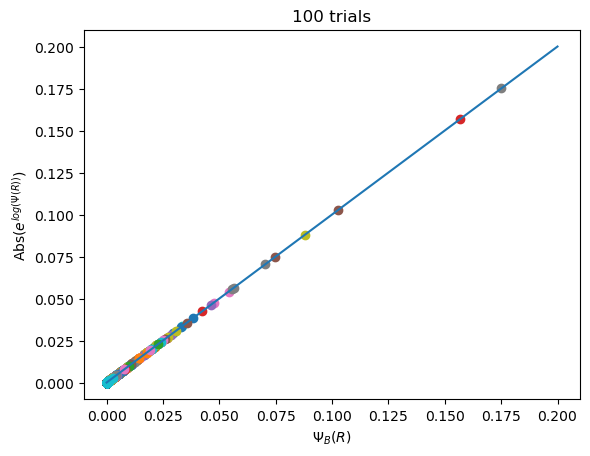

In [51]:
#phi and phib
trials = 100
for i in range(trials):
    nconfig = 100
    mol, mf = pyscftools.recover_pyscf(scf_checkfile)
    configs = bosonmc.initial_guess(mol, nconfig, seed = i)
    wfb = initialize_boson_qmc_objects_j(
        scf_checkfile,
    )
    wf = initialize_qmc_objects_j(
            scf_checkfile,
        )
    e=0
    sign, phi1 = wf.recompute(configs)
    g1, phi, saved1 = wf.gradient_value(e, configs.electron(e))  
    # phi1a = saved['phi']
    e=0
    signb, phi2 = wfb.recompute(configs)
    g1b, saved2 = wfb.gradient_value(e, configs.electron(e))
    phi2a = saved2['psi']
    
    plt.scatter(np.exp(phi1), phi2)
x = np.linspace(0, 0.2, 100)
plt.plot(x,x)
plt.xlabel(r'$\Psi_B(R)$')
plt.ylabel(r'Abs($e^{log(\Psi(R))}$)')
plt.title(str(trials) + ' trials')

Text(0.5, 1.0, '100 configurations')

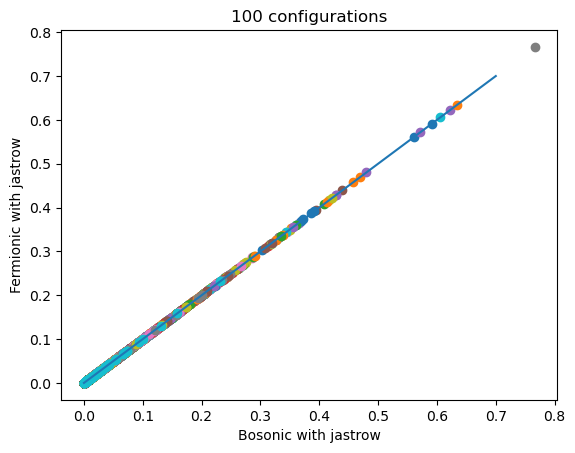

In [36]:
#Val and valb
trials = 100
for i in range(trials):
    nconfig = 100
    mol, mf = pyscftools.recover_pyscf(scf_checkfile)
    configs = bosonmc.initial_guess(mol, nconfig, seed = i)
    wfb = initialize_boson_qmc_objects_j(
        scf_checkfile,
    )
    wf = initialize_qmc_objects_j(
            scf_checkfile,
        )
    e=0
    sign, val = wf.recompute(configs)
    g1, val2, (aograd, mograd) = wf.gradient_value(e, configs.electron(e))  
    e=0
    signb, valb = wfb.recompute(configs)
    g1b, saved = wfb.gradient_value(e, configs.electron(e))
    valb2 = saved['psi']
    plt.scatter(np.exp(val), valb)
x = np.linspace(0, 0.7, 100)
plt.plot(x,x)
plt.xlabel('Bosonic with jastrow')
plt.ylabel('Fermionic with jastrow')
plt.title(str(trials) + ' configurations')